In [1]:
import data
#from mlp_np import *

In [33]:
"""
A simple implementation of a MLP using NumPy
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit # numerically stable sigmoid function
import VisualizeNN as VisNN
from celluloid import Camera # getting the camera
from IPython.display import HTML
from time import localtime, strftime



# Activation functions
def linear(x):
    return x

def linear_der(x):
    return 1

def tanh(x):
    return np.tanh(x)

def tanh_der(x):
    return 1-np.tanh(x)**2


def sigmoid(x):
    return expit(x)

def sigmoid_der(x):
    u = sigmoid(x)
    return u*(1-u)

def relu(x):
    return x*(x>0)

def relu_der(x):
    return (x>0)

# Weight initialization
def kaiming(network_config, l):
    return np.random.normal(size=(network_config[l+1], network_config[l])) * np.sqrt(2./network_config[l])

# Multilayer Perceptron Class
class NeuralNetwork(object):

    def __init__(self, network_config,Classifier=True,activations=None):

        if activations is None: activations = (len(network_config)-1)*("relu",)+(  "sigmoid" if Classifier else "relu",   ) 
        self.activations = activations
        self.Classifier = Classifier
        self.n_layers = len(network_config)

        # Weights
        self.W = [kaiming(network_config, l) for l in range(self.n_layers-1)]
        # Bias
        self.b = [np.zeros((network_config[l], 1)) for l in range(1, self.n_layers)]

        # Pre-activation
        self.z = [None for l in range(1, self.n_layers)]
        # Activations
        self.a = [None for l in range(self.n_layers)]
        # Gradients
        self.dW = [None for l in range(self.n_layers-1)] 
        self.db = [None for l in range(1, self.n_layers)]

    def grouped_rand_idx(self, n_total, batch_size):
        idx = np.random.permutation(n_total)
        return [idx[i:i+batch_size] for i in range(0, len(idx), batch_size)]
    

    def train(self, x_train, y_train, x_valid, y_valid, x_test, y_test, epochs, batch_size, learning_rate):
        self.history={ "train" :{"acc":[] ,  "loss":[]},"valid" :{"acc":[] ,  "loss":[]},"test" :{"acc":[] ,  "loss":[]} }
        eta = learning_rate / batch_size
        visualize_each = int(epochs/30)
        for epoch in range(epochs):

            self.prediction(x_train, y_train, epoch, mode="train",printp = epoch % visualize_each == 0)
            self.prediction(x_valid, y_valid, epoch, mode="valid")
            
            if epoch % visualize_each == 0:
                self.visualize_weights(epoch)

            idx_list = self.grouped_rand_idx(len(x_train), batch_size)
            for idx in idx_list:
                # Get batch of random training samples
                x_batch, y_batch = x_train[idx], y_train[idx]
                self.feedforward(x_batch) 
                self.backprop_gradient_descent(y_batch, eta)

        self.visualize_weights(epoch+1)
        self.prediction(x_valid, y_valid, epoch+1, mode="valid")
        self.prediction(x_train, y_train, epoch, mode="train")
        # Compute test accuracy and loss
        self.prediction(x_test, y_test, epoch+1, mode="test")

    def backprop_gradient_descent(self, Y, eta):
        # Backpropagation
        if self.activations[-1]=="sigmoid":
            delta = (self.a[-1] - Y) * sigmoid_der(self.z[self.n_layers-2]) 
        elif self.activations[-1]=="linear":
            delta = (self.a[-1] - Y) * linear_der(self.z[self.n_layers-2]) 
        elif self.activations[-1]=="tanh":
            delta = (self.a[-1] - Y) * tanh_der(self.z[self.n_layers-2]) 
        else:
            delta = (self.a[-1] - Y) * relu_der(self.z[self.n_layers-2])
            
        self.dW[self.n_layers-2] = np.matmul(delta.T, self.a[self.n_layers-2])
        self.db[self.n_layers-2] = np.sum(delta.T, axis=1, keepdims=True)

        for l in reversed(range(self.n_layers-2)):
            if self.activations[l]=="sigmoid":
                delta = np.matmul(delta, self.W[l+1]) * sigmoid_der(self.z[l])
            elif self.activations[l]=="linear":
                delta = np.matmul(delta, self.W[l+1]) * linear_der(self.z[l])
            elif self.activations[l]=="tanh":
                delta = np.matmul(delta, self.W[l+1]) * tanh_der(self.z[l])
            else:
                delta = np.matmul(delta, self.W[l+1]) * relu_der(self.z[l])
            self.dW[l] = np.matmul(self.a[l].T, delta).T
            self.db[l] = np.sum(delta.T, axis=1, keepdims=True)

        # Gradient descent: Update Weights and Biases
        for l in range(self.n_layers-1):
            self.W[l] -= eta * self.dW[l]
            self.b[l] -= eta * self.db[l]

        # Reset gradients
        self.dW = [None for l in range(self.n_layers-1)]
        self.db = [None for l in range(self.n_layers-1)]

    def feedforward(self, X):
        self.a[0] = X 
        for l in range(self.n_layers-1):
            self.z[l] = np.matmul(self.a[l], self.W[l].T) + self.b[l].T     # Pre-activation hidden layer
            if self.activations[l]=="sigmoid":
                self.a[l+1] = sigmoid(self.z[l])
            elif self.activations[l]=="linear":
                self.a[l+1] = linear(self.z[l])
            elif self.activations[l]=="tanh":
                self.a[l+1] = tanh(self.z[l])
            else:
                self.a[l+1] = relu(self.z[l])
        # Activation hidden layer
    
    def pred(self, X, Y):
        neurons = X
        for l in range(self.n_layers-1):
            if self.activations[l]=="sigmoid":
                neurons = sigmoid(np.matmul(neurons, self.W[l].T) + self.b[l].T)
            elif self.activations[l]=="linear":
                neurons = linear(np.matmul(neurons, self.W[l].T) + self.b[l].T)
            elif self.activations[l]=="tanh":
                neurons = tanh(np.matmul(neurons, self.W[l].T) + self.b[l].T)
            else:
                neurons = relu(np.matmul(neurons, self.W[l].T) + self.b[l].T)
        if self.Classifier:
                neurons =np.where(neurons<0.5,0,1)
        logits =neurons
        
        if self.activations[-1]=="sigmoid":
            output =logits
            if self.Classifier:
                accuracy = (np.argmax(logits, axis=1) == np.argmax(Y, axis=1)).sum() / len(X)
            else:
                accuracy = (np.argmax(logits, axis=1) == np.argmax(Y, axis=1)).sum() / len(X)
            loss = np.sum((Y - sigmoid(logits))**2) / len(X)
        else:
            output =logits
            loss = np.sum((Y - logits)**2) / len(X)
            accuracy = 1/(1+loss)
        return output,loss, accuracy

    def prediction(self, X, Y, epoch, mode,printp=False):
        output,loss, accuracy = self.pred(X, Y)
        self.history[mode]["loss"].append(loss)
        self.history[mode]["acc"].append(accuracy)
        if printp: 
            print('val epoch {1} {0}_loss {2:.6f} {0}_accuracy {3:.4f}'.format(mode, epoch, loss, accuracy), sep=' ', end="\r", flush=True)

    def predict(self, X):
        neurons = X
        for l in range(self.n_layers-1):
            if self.activations[l]=="sigmoid":
                neurons = sigmoid(np.matmul(neurons, self.W[l].T) + self.b[l].T)
            elif self.activations[l]=="linear":
                neurons = linear(np.matmul(neurons, self.W[l].T) + self.b[l].T)
            elif self.activations[l]=="tanh":
                neurons = tanh(np.matmul(neurons, self.W[l].T) + self.b[l].T)
            else:
                neurons = relu(np.matmul(neurons, self.W[l].T) + self.b[l].T)
        if self.Classifier:
                neurons =np.where(neurons<0.5,0,1)
        return neurons

    def visualize_weights(self, epoch):
        return

    def visualize(self,fig=None,epoch=0):
        
        network=VisNN.DrawNN(self.network_structure(),self._coefs(),self._bias())
        return network.draw( fig= fig,epoch=epoch)
    
    def  network_structure(self):
        structure=[len(self.W[0][0])]
        for W in self.W:
            structure.append(len(W))
        return np.array(structure)
    
    def _coefs(self):
        weights=[]
       
        for W in self.W:
            _weights=[[] for i in range(len( W[0] ))] 
            for Wx in W:
                for i,weight in enumerate(Wx):
                    _weights[i].append(weight)
            weights.append(np.array(_weights))
        return weights
    
    def _bias(self):
        bias=[]            
        for b in self.b:
            bias.append([_b[0] for _b in  b ])
        return bias

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def draw_metrics(mdl,x_test,y_test):
    f,ax= plt.subplots(2, 2, sharex='col',figsize=(12,12))
    draw_loss_metrics(mdl.history['train']["loss"],mdl.history['valid']["loss"],ax[0,0])
    draw_accuracy_metrics(mdl.history['train']["acc"],mdl.history['valid']["acc"],ax[1,0])
    if mdl.Classifier :draw_matrix_confusion(np.argmax(y_test, axis=1) ,np.argmax(mdl.predict(x_test), axis=1)  ,ax[0,1])
    plt.show()
    
def draw_loss_metrics(loss_train,loss_val,ax):

    ax.plot(range(0,len(loss_train)), loss_train, 'g', label='Training loss')
    ax.plot(range(0,len(loss_val)), loss_val, 'b', label='validation loss')
    ax.set_title('Training and Validation loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    #ax.show()
    
def draw_accuracy_metrics(acc_train,acc_val,ax):
    ax.plot(range(0,len(acc_train)), acc_train, 'g', label='Training accuracy')
    ax.plot(range(0,len(acc_val)), acc_val, 'b', label='validation accuracy')
    ax.set_title('Training and Validation accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.legend()
    #ax.show()
    
def draw_matrix_confusion(y,y_pred,ax):

    cf_matrix = confusion_matrix(y.reshape(len(y)), y_pred.reshape(len(y_pred)))
    sn.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,  fmt='.2%', cmap='Blues',ax=ax)
    #ax.show()

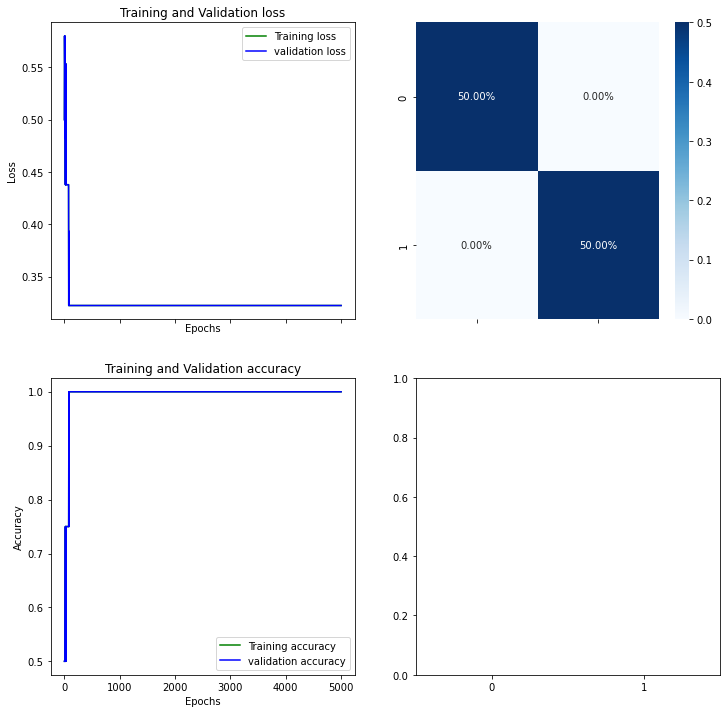

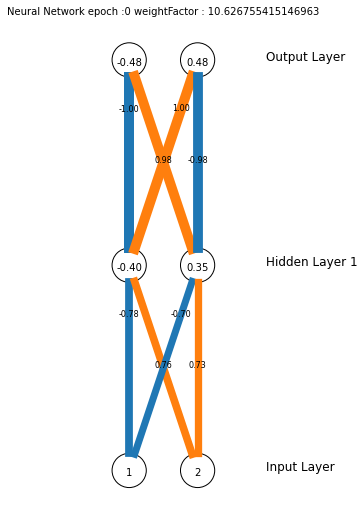

In [39]:
# XOR
# Load data 
x_train = np.array([[0,0], [0,1], [1,0], [1,1]])
y_train= np.array([[1,0], [0,1], [0,1], [1,0]])
x_valid= np.array([[0,0], [0,1], [1,0], [1,1]])
y_valid=np.array([[1,0], [0,1], [0,1], [1,0]])
x_test= np.array([[0,0], [0,1], [1,0], [1,1]])
y_test=np.array([[1,0], [0,1], [0,1], [1,0]])

n_output=2
n_input = 2

# Training parameters
learning_rate = 5
batch_size = 1
epochs = 5000

# Network configuration
network_config = (n_input,)     +(2,)        +(n_output,)

activations =    2*("sigmoid",)

# Initialize network

network = NeuralNetwork( network_config, activations=activations ,Classifier=True)

network.train(x_train, y_train, x_valid, y_valid, x_test, y_test, epochs, batch_size, learning_rate)

network.predict(x_train)

draw_metrics(network,x_test,y_test)
a=network.visualize()

In [5]:
network.predict(x_train)

array([[0.00204555],
       [0.99769697],
       [0.99769684],
       [0.00211949]])

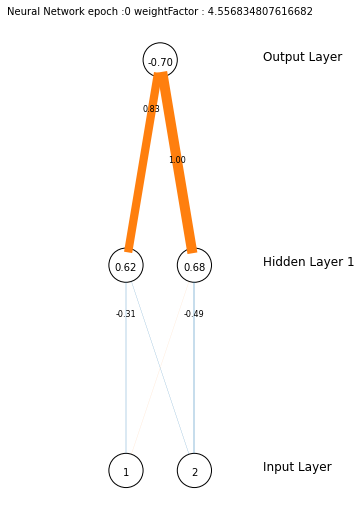

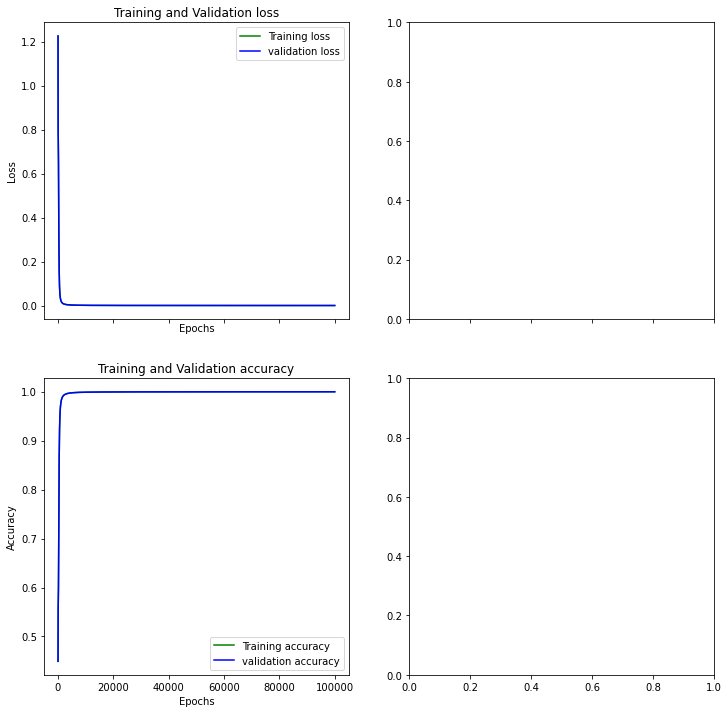

In [40]:
# Load data
X = np.array([
      [1, 1],
      [2, 3],
      [3, 3]
])
Y = np.array([
     [ 1],
      [-1],
      [-1]
])

n_output=1
n_input = 2

# Training parameters
learning_rate = 0.1
batch_size = 4
epochs = 100000

# Network configuration
network_config = (n_input,) +(2,) +(n_output,)

activations =  ("sigmoid",)+("tanh",)
# Initialize network
network = NeuralNetwork(network_config,activations=activations,Classifier=False)
network.train(X, Y, X, Y, X, Y, epochs, batch_size, learning_rate)
a=network.visualize()
network.predict(X)
draw_metrics(network,X,Y)

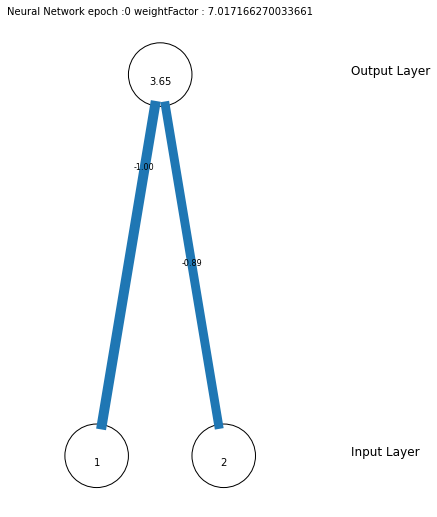

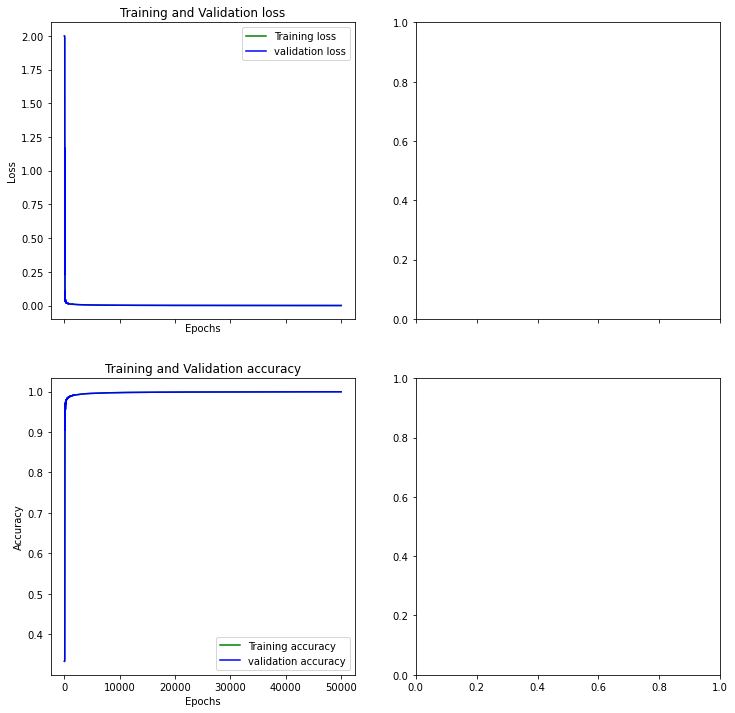

In [42]:
X = np.concatenate([np.random.random((50,2)) * 0.9 + np.array([1, 1]), np.random.random((50,2)) * 0.9 + np.array([2, 2])])
Y = np.concatenate([np.ones((50, 1)), np.ones((50, 1)) * -1.0])

n_input = 2
n_output=1

# Training parameters
learning_rate = 1
batch_size = 50
epochs = 50000

# Network configuration
network_config = (n_input,) +(n_output,)
activations =  ("tanh",)
# Initialize network
network = NeuralNetwork(network_config,activations=activations,Classifier=False)
network.train(X, Y, X, Y, X, Y, epochs, batch_size, learning_rate)
a=network.visualize()
draw_metrics(network,X,Y)

### Cross :
        Linear Model    : KO
        MLP (2, 4, 1)   : OK

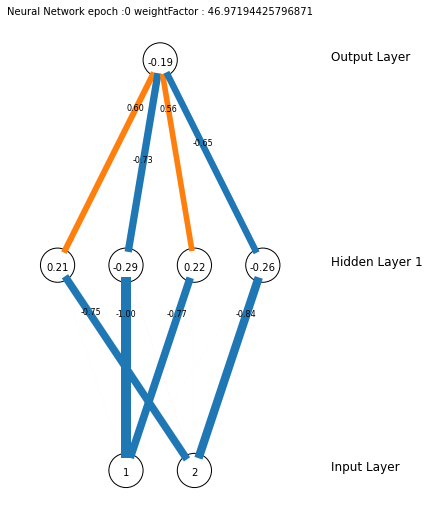

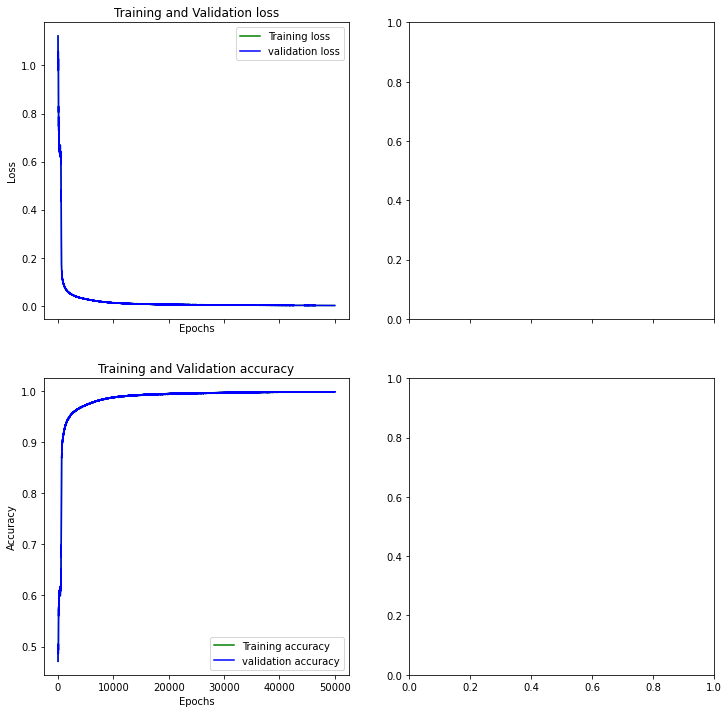

In [43]:
#CROSS 

X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([[1] if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else [-1] for p in X])


n_input = 2
n_output=1

# Training parameters
learning_rate = 0.5
batch_size = 40
epochs = 50000

# Network configuration
network_config = (n_input,)+(4,) +(n_output,)
activations =   ("sigmoid",)+("tanh",)
# Initialize network
network = NeuralNetwork(network_config,activations=activations,Classifier=False)
network.train(X, Y, X, Y, X, Y, epochs, batch_size, learning_rate)
a=network.visualize()
draw_metrics(network,X,Y)

### Multi Linear 3 classes :
        Linear Model x3 : OK
        MLP (2, 3)      : OK

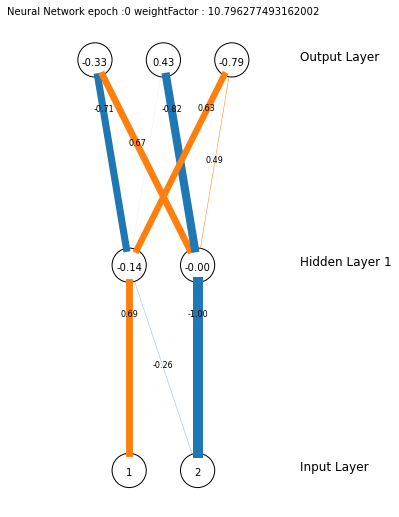

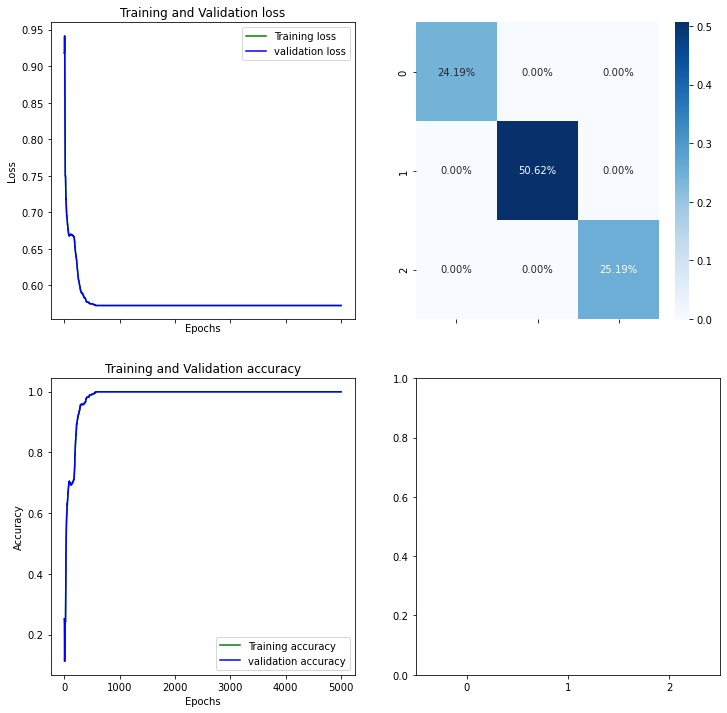

In [47]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([[1, 0, 0] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else 
              [0, 1, 0] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else 
              [0, 0, 1] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else 
              [0, 0, 0]for p in X])

X = X[[not np.all(arr == [0, 0, 0]) for arr in Y]]
Y = Y[[not np.all(arr == [0, 0, 0]) for arr in Y]]

n_input = 2
n_output=3

# Training parameters
learning_rate = 1
batch_size = 400
epochs = 5000

# Network configuration
network_config = (n_input,)+(2,) +(n_output,)
activations =   ("sigmoid",)+("sigmoid",)
# Initialize network
network = NeuralNetwork(network_config,activations=activations,Classifier=True)
network.train(X, Y, X, Y, X, Y, epochs, batch_size, learning_rate)
a=network.visualize()
draw_metrics(network,X,Y)

In [49]:
from tqdm import tqdm
from PIL import Image, ImageOps 
import matplotlib.pyplot as plt
import matplotlib.image as img


def preprocess_dataset(paths, img_size):
    list_X, list_Y ,images = [], [],[]
    for path in paths:
        images = images+ [path + "/" + i  for i in os.listdir(path) ] 
    np.random.shuffle(images)
    
    for filename in tqdm(images):
        if "." in filename:
            img = ImageOps.grayscale(Image.open(filename).resize(img_size))
            array = np.asarray(img).flatten().tolist()

            #plt.imshow(img, cmap='gray', vmin = 0, vmax = 255,interpolation='none')
            #plt.show()
            list_X.append(array)

            if "pizza" in filename:
                class_array =[1,0,0]
            elif "tarte aux pommes" in filename:
                class_array =[0,1,0]
            elif "tarte aux fraises" in filename:
                class_array =[0,0,1]

            list_Y.append(class_array)

    X, Y = np.array(list_X), np.array(list_Y)
    return X / 255. ** 2, Y

100%|██████████| 69/69 [00:00<00:00, 2800.23it/s]


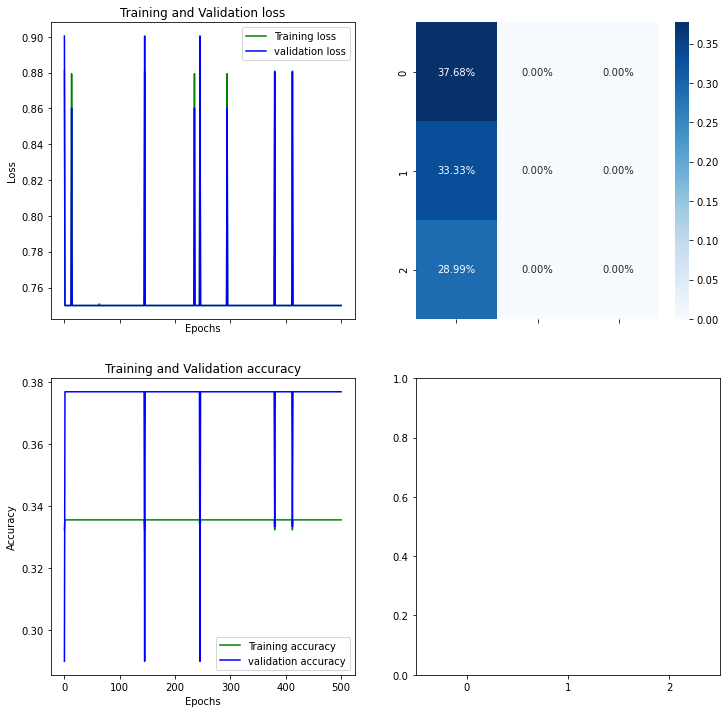

In [75]:

X, Y = preprocess_dataset(["dataset/train/pizza",
                          "dataset/train/tarte aux pommes",
                         "dataset/train/tarte aux fraises"],
                          (32, 32))
Xtest, Ytest = preprocess_dataset(["dataset/test/pizza",
                          "dataset/test/tarte aux pommes",
                         "dataset/test/tarte aux fraises"],
                          (32, 32))

Xvalidate, Yvalidate = preprocess_dataset(["dataset/test/pizza",
                          "dataset/test/tarte aux pommes",
                         "dataset/test/tarte aux fraises"],
                          (32, 32))

# Training parameters
learning_rate = 0.1
batch_size = 50
epochs = 500

# Network configuration
network_config = (len(X[0]),) + 3*(32*32,) + (len(Y[0]),)
activations =  2*("relu",)+2*("sigmoid",)
# Initialize network
network = NeuralNetwork(network_config,activations=activations,Classifier=True)

# Start training
network.train(X,Y,Xtest,Ytest,Xvalidate,Yvalidate,epochs, batch_size, learning_rate)
draw_metrics(network,Xtest,Ytest)

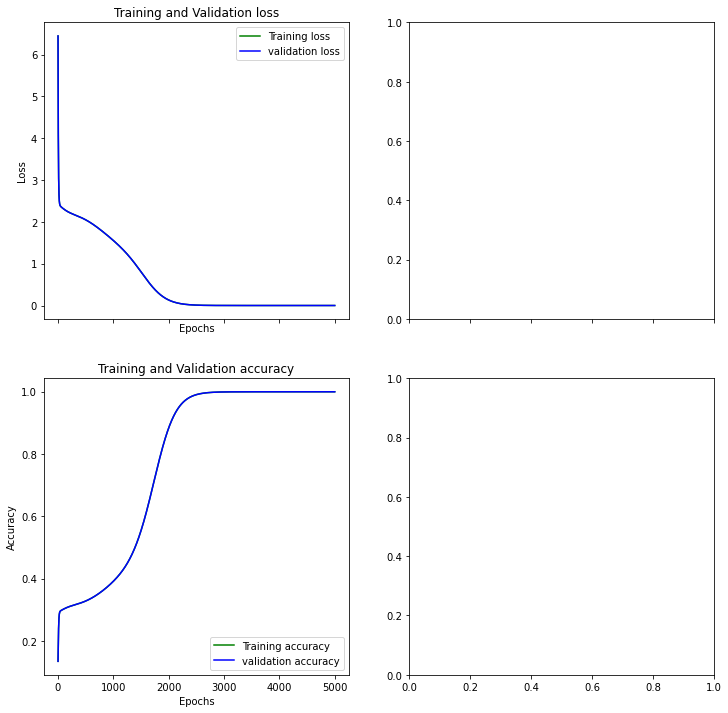

In [56]:
X = np.array([
      [1, 0],
      [0, 1],
      [1, 1],
      [0, 0],
])
Y = np.array([
     [ 2],
      [1],
      [-2],
      [-1]
])


# Training parameters
learning_rate = 0.1
batch_size = 10   
epochs = 5000

# Network configuration
network_config = (len(X[0]),) + (4,) + (len(Y[0]),)
activations =                   ("sigmoid",)+("linear",)
# Initialize network
network = NeuralNetwork(network_config,activations=activations,Classifier=False)

# Start training
network.train(X,Y,X,Y,X,Y,epochs, batch_size, learning_rate)
draw_metrics(network,X,Y)

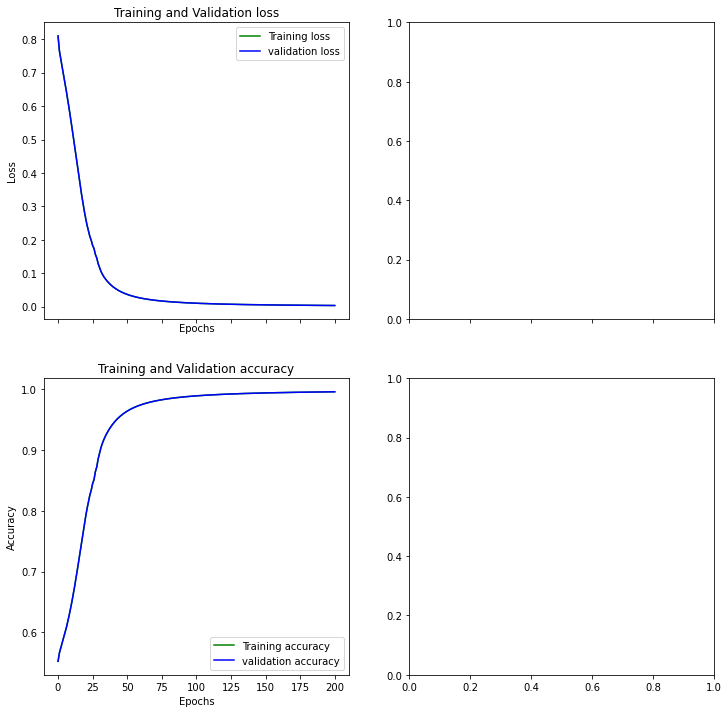

In [74]:
X = np.array([
      [1, 1],
      [2, 3],
      [3, 3]
])
Y = np.array([
      [1],
      [-1],
      [-1]
])


# Training parameters
learning_rate = 1
batch_size = 3    
epochs = 200

# Network configuration
network_config = (len(X[0]),) + 1*(2,) + (len(Y[0]),)
activations =                   ("sigmoid",)+("tanh",)
# Initialize network
network = NeuralNetwork(network_config,activations=activations,Classifier=False)

# Start training
network.train(X,Y,X,Y,X,Y,epochs, batch_size, learning_rate)
draw_metrics(network,X,Y)